### Import Packages

In [2]:
import copy
import datetime
import os
import pathlib

import numpy as np
import pytorch_lightning as pl
import torch
import yaml
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import CosineAnnealingLR

import tsl
from tsl.data import SpatioTemporalDataModule
from tsl.data.imputation_stds import ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import (AirQuality,
                          MetrLA,
                          PemsBay)
from tsl.imputers import Imputer
from tsl.nn.metrics.metrics import MaskedMAE, MaskedMAPE, MaskedMSE, MaskedMRE
from tsl.nn.models.imputation import (RNNImputerModel,
                                      BiRNNImputerModel,
                                      GRINModel)
from tsl.nn.utils import casting
from tsl.ops.imputation import add_missing_values
from tsl.utils import TslExperiment, ArgParser, parser_utils, numpy_metrics
from tsl.utils.neptune_utils import TslNeptuneLogger
from tsl.utils.parser_utils import str_to_bool
import pandas as pd
import sys
sys.argv = ['run.py']

tsl.config.config_dir = os.path.join(os.path.dirname(os.path.realpath('Pune_GRIN')),'config')
from datetime import datetime, timedelta, timezone
import warnings
warnings.filterwarnings('ignore')

/Users/chetan/opt/anaconda3/envs/DataImputation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
from typing import Optional, Sequence, List

import numpy as np
import pandas as pd

from tsl.data.datamodule.splitters import disjoint_months, Splitter
from tsl.ops.dataframe import compute_mean
from tsl.ops.similarities import gaussian_kernel
from tsl.ops.similarities import geographical_distance
from tsl.utils import download_url, extract_zip
from tsl.datasets.prototypes import PandasDataset
from tsl.datasets.prototypes.mixin import MissingValuesMixin
from tsl.data.utils import HORIZON
from argparse import ArgumentParser

In [4]:
from typing import Type, Mapping, Callable, Optional, Union, Tuple, List

import torch
from torch import Tensor
from torch_geometric.data.storage import recursive_apply
from torchmetrics import Metric

from tsl.predictors import Predictor
from matplotlib import pyplot as plt
import random

### Initialize variables to get Date-Time object for Sensor Measurements for every 15 min interval

In [5]:
start_date = '2020-10-16 00:05:30'     # Starting date-time for data
#date_format_str = '%Y-%m-%d %H:%M:%S%z'
date_format_str = '%Y-%m-%d %H:%M:%S'  # Date-time format
end_date = '2022-07-21 00:05:30'       # Ending date-time for data
d0 = datetime.strptime(start_date, date_format_str) # Converting starting date-time string to datetime Object
d1 = datetime.strptime(end_date, date_format_str)   # Converting ending date-time string to datetime Object
diff = d1-d0      # Get difference between stating date-time object to ending date-time object
sampling_frequency = 0.25       # Sampling frequency (0.25 = 15min, 0.5 = 30min, 1 = 1hr)
end_slot = start_date           # Initiate ending time slot as the starting time
start_slot = datetime.strptime(start_date, date_format_str) # Initiate starting time slot as the starting time
                                                            # Initially start and end slots are the same (before iteration)

### Get Date-Time object for Sensor Measurements for every 15 min interval

In [6]:
DateTime = start_slot  # Variable to store date-time object data, Initiate DateTime with starting date-time object and store 
for j in range(int(diff.days*24*(1/sampling_frequency))):      # Loop to get date-time objects for sensor data
    end_slot = start_slot+timedelta(hours = sampling_frequency) # Change end_slot for the loop by adding 15 mins to start_slot
    start_slot = end_slot    # Change start_slot for the next loop by assiging end_slot to start_slot
    DateTime = np.append(DateTime, start_slot)  # Append new start_slot (next date-time object) to DateTime variable

### Load and Manipulate data

In [86]:
Tdata = pd.read_csv('pune_aqm_2020Oct_2022July_NoOutliers_NaN.csv') # Load data to DataFrame (preprocessed to remove outliers)
Tdata = Tdata.drop('Unnamed: 0.1', axis = 1) # Drop column
Tdata = Tdata.drop('Unnamed: 0', axis = 1) # Drop column
#Tdata = Tdata.iloc[:,59000:] 
Testdata = Tdata.T # Data transpose
Testdata['datetime'] = DateTime[:-1] # Add new column 'datetime' to dataframe
#Testdata['datetime'] = DateTime[59000:-1]
Testdata.reset_index(inplace = True)  # Reset dataframe index
Testdata = Testdata.drop('index',axis = 1) # Drop index column
#Tdata.set_index("datetime", inplace = True)
stations = pd.read_csv('/Users/chetan/opt/anaconda3/envs/KrigingIGNNK/pune_sensor.csv') # Load Station or sensor Data
Testdata.shape

(61728, 51)

### Create Mask for test data. Mast to Remove existing sampled values for testing

In [87]:
mask_arr = np.zeros([Testdata.shape[0],Testdata.shape[1]])  # Crate a mask array with zero matrix with equal size as Testdata
for i in range(50):     # Loop to create mask for every sensor
    Non_NaNs = Testdata[Testdata.iloc[:,i].notnull()].index  # Extract numerical values index
    indices = np.sort(np.random.choice(Non_NaNs, size=int(np.round(len(Non_NaNs)*0.3)), replace=False)) # Get 30% of indices from Non_NaNs list without replacing values
    mask_arr[indices,i] = 1   # Replace zeros of i'th column corresponding to indices with 1 to create a mask for each sensor 
    Testdata.iloc[indices,i] = np.nan # Replace the values corresponding to indices in the Testdata with NaN

##### Reset Index to 'datetime'

In [88]:
Testdata.set_index("datetime", inplace = True)
Testdata

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
datetime,,,,,,,,,,,,,,,,,,,,,
2020-10-16 00:05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-16 00:20:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-16 00:35:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-16 00:50:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-16 01:05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-20 22:50:30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,4.0,NaN,...,NaN,0.0,4.0,0.0,NaN,NaN,0.0,0.0,7.0,NaN
2022-07-20 23:05:30,20.0,NaN,3.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,...,132.0,NaN,3.0,0.0,NaN,NaN,NaN,0.0,4.0,NaN
2022-07-20 23:20:30,13.0,NaN,3.0,2.0,NaN,NaN,NaN,0.0,NaN,NaN,...,26.0,0.0,0.0,NaN,13.0,NaN,NaN,NaN,3.0,NaN


## Class to prepare data for GRIN

In [89]:
def infer_mask(df, infer_from='next'):
    """Infer evaluation mask from DataFrame. In the evaluation mask a value is 1
    if it is present in the DataFrame and absent in the :obj:`infer_from` month.
    Args:
        df (pd.Dataframe): The DataFrame.
        infer_from (str): Denotes from which month the evaluation value must be
            inferred. Can be either :obj:`previous` or :obj:`next`.
    Returns:
        pd.DataFrame: The evaluation mask for the DataFrame.
    """
    mask = (~df.isna()).astype('uint8')
    eval_mask = pd.DataFrame(index=mask.index, columns=mask.columns,
                             data=0).astype('uint8')
    if infer_from == 'previous':
        offset = -1
    elif infer_from == 'next':
        offset = 1
    else:
        raise ValueError('`infer_from` can only be one of {}'
                         .format(['previous', 'next']))

    months = sorted(set(zip(mask.index.year, mask.index.month)))
    length = len(months)
    for i in range(length):
        j = (i + offset) % length
        year_i, month_i = months[i]
        year_j, month_j = months[j]
        cond_j = (mask.index.year == year_j) & (mask.index.month == month_j)
        mask_j = mask[cond_j]
        offset_i = 12 * (year_i - year_j) + (month_i - month_j)
        mask_i = mask_j.shift(1, pd.DateOffset(months=offset_i))
        mask_i = mask_i[~mask_i.index.duplicated(keep='first')]
        mask_i = mask_i[np.in1d(mask_i.index, mask.index)]
        i_idx = mask_i.index
        eval_mask.loc[i_idx] = ~mask_i.loc[i_idx] & mask.loc[i_idx]
    return eval_mask


class AirPM25Splitter(Splitter):

    def __init__(self, val_len: int = None,
                 test_months: Sequence = (3, 6, 9, 12)):
        super(AirPM25Splitter, self).__init__()
        self._val_len = val_len
        self.test_months = test_months

    def fit(self, dataset):
        nontest_idxs, test_idxs = disjoint_months(dataset,
                                                  months=self.test_months,
                                                  synch_mode=HORIZON)
        # take equal number of samples before each month of testing
        val_len = self._val_len
        if val_len < 1:
            val_len = int(val_len * len(nontest_idxs))
        val_len = val_len // len(self.test_months)
        # get indices of first day of each testing month
        delta = np.diff(test_idxs)
        delta_idxs = np.flatnonzero(delta > delta.min())
        end_month_idxs = test_idxs[1:][delta_idxs]
        if len(end_month_idxs) < len(self.test_months):
            end_month_idxs = np.insert(end_month_idxs, 0, test_idxs[0])
        # expand month indices
        month_val_idxs = [np.arange(v_idx - val_len, v_idx) - dataset.window
                          for v_idx in end_month_idxs]
        val_idxs = np.concatenate(month_val_idxs) % len(dataset)
        # remove overlapping indices from training set
        ovl_idxs, _ = dataset.overlapping_indices(nontest_idxs, val_idxs,
                                                  synch_mode=HORIZON,
                                                  as_mask=True)
        train_idxs = nontest_idxs[~ovl_idxs]
        self.set_indices(train_idxs, val_idxs, test_idxs)


class AirPM25(PandasDataset, MissingValuesMixin):
    """Measurements of pollutant :math:`PM2.5` collected by 437 air quality
    monitoring stations spread across 43 Chinese cities from May 2014 to April
    2015.
    See more at https://www.microsoft.com/en-us/research/project/urban-air/"""
    url = "https://drive.switch.ch/index.php/s/W0fRqotjHxIndPj/download"

    similarity_options = {'distance'}
    temporal_aggregation_options = {'mean', 'nearest'}
    spatial_aggregation_options = {'mean'}

    def __init__(self, root: str = None,
                 impute_nans: bool = True,
                 small: bool = False,
                 test_months: Sequence = (3, 6, 9, 12),
                 infer_eval_from: str = 'next',
                 freq: Optional[str] = None,
                 masked_sensors: Optional[Sequence] = None):
        self.root = root
        self.small = small
        self.test_months = test_months
        self.infer_eval_from = infer_eval_from  # [next, previous]
        if masked_sensors is None:
            self.masked_sensors = []
        else:
            self.masked_sensors = list(masked_sensors)
        df, mask, eval_mask, dist = self.load(impute_nans=impute_nans)
        super().__init__(dataframe=df,
                         attributes=dict(dist=dist),
                         mask=mask,
                         freq=freq,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         default_splitting_method='air_quality',
                         name='AQI36' if self.small else 'PM25')
        self.set_eval_mask(eval_mask)

    @property
    def raw_file_names(self) -> List[str]:
        return ['full437.h5', 'small36.h5']

    @property
    def required_file_names(self) -> List[str]:
        return self.raw_file_names + ['aqi_dist.npy']

    def download(self):
        path = download_url(self.url, self.root_dir, 'data.zip')
        print(path)
        extract_zip(path, self.root_dir)
        os.unlink(path)

    def build(self):
        self.maybe_download()
        # compute distances from latitude and longitude degrees
        path = os.path.join(self.root_dir, 'full437.h5')
        stations = pd.DataFrame(pd.read_hdf(path, 'stations'))
        st_coord = stations.loc[:, ['latitude', 'longitude']]
        dist = geographical_distance(st_coord, to_rad=True).values
        np.save(os.path.join(self.root_dir, 'aqi_dist.npy'), dist)

    def load_raw(self):
        st_coord = stations.loc[:, ['latitude', 'longitude']]
        dist = geographical_distance(st_coord, to_rad=True).values
        eval_mask = None
        df = Testdata
        return df, dist, eval_mask

    def load(self, impute_nans=True):
        # load readings and stations metadata
        df, dist, eval_mask = self.load_raw()
        # compute the masks:
        mask = (~np.isnan(df.values)).astype('uint8')  # 1 if value is valid
        if eval_mask is None:
            eval_mask = infer_mask(df, infer_from=self.infer_eval_from)
        # 1 if value is ground-truth for imputation
        eval_mask = eval_mask.values.astype('uint8')
        if len(self.masked_sensors):
            eval_mask[:, self.masked_sensors] = mask[:, self.masked_sensors]
        # eventually replace nans with weekly mean by hour
        if impute_nans:
            df = df.fillna(compute_mean(df))
        return df, mask, eval_mask, dist

    def get_splitter(self, method: Optional[str] = None, **kwargs):
        if method == 'air_quality':
            val_len = kwargs.get('val_len')
            return AirPM25Splitter(test_months=self.test_months,
                                      val_len=val_len)

    def compute_similarity(self, method: str, **kwargs):
        if method == "distance":
            # use same theta for both air and air36
            theta = np.std(self.dist[:36, :36])
            return gaussian_kernel(self.dist, theta=theta)

### Function to preprocess the data using above Class

In [90]:
def get_dataset(dataset_name: str, p_fault=0., p_noise=0.):
    if dataset_name.startswith('air'):
        return AirPM25(impute_nans=True)

### Function to get model class (GRIN)

In [91]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model

### Function Arguments Parser (parameters for GRIN model training)

In [92]:
def add_parser_arguments(parent):
    # Argument parser
    parser = ArgParser(strategy='random_search', parents=[parent],
                       add_help=False)

    parser.add_argument('--seed', type=int, default=-1)
    parser.add_argument('--precision', type=int, default=32)
    parser.add_argument("--model-name", type=str, default='grin')
    parser.add_argument("--dataset-name", type=str, default='air')
    parser.add_argument("--config", type=str, default='grin.yaml')

    # Injected missing params
    parser.add_argument('--p-fault', type=float, default=0.)
    parser.add_argument('--p-noise', type=float, default=0.)

    # Splitting params
    parser.add_argument('--in-sample', type=str_to_bool, nargs='?', const=True,
                        default=True)
    parser.add_argument('--val-len', type=float, default=0.1)
    parser.add_argument('--test-len', type=float, default=0.2)

    # Training params
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--l2-reg', type=float, default=0.)
    parser.add_argument('--epochs', type=int, default=10)   ## Default = 300
    parser.add_argument('--batches-per-epoch', type=int, default=80)
    parser.add_argument('--patience', type=int, default=50)
    parser.add_argument('--grad-clip-val', type=float, default=5.)
    parser.add_argument('--use-lr-schedule', type=str_to_bool, nargs='?',
                        const=True, default=True)

    # Logging params
    parser.add_argument('--save-preds', action='store_true', default=False)
    parser.add_argument('--neptune-logger', action='store_true', default=False)
    parser.add_argument('--project-name', type=str, default="sandbox")
    parser.add_argument('--tags', type=str, default=tuple())
    # parser.add_argument('--aggregate-by', type=str, default='mean')

    known_args, _ = parser.parse_known_args()
    model_cls = get_model_class(known_args.model_name)
    parser = model_cls.add_model_specific_args(parser)
    parser = ImputationDataset.add_argparse_args(parser)
    parser = SpatioTemporalDataModule.add_argparse_args(parser)
    parser = Imputer.add_argparse_args(parser)
    return parser

### Check configuration file and update parameters (if necessary) for model training

In [93]:
def _check_config(hparams):
    config_file = hparams.__dict__.get('config', None)
    if config_file is not None:
        # read config file
        import yaml
        config_path = None
        config_root = config_path if config_path is not None else tsl.config.config_dir
        config_file = os.path.join(config_root, config_file)
        with open(config_file, 'r') as fp:
            experiment_config = yaml.load(fp, Loader=yaml.FullLoader)

        # update hparams
        hparams = parser_utils.update_from_config(hparams, experiment_config)
        if hasattr(parser, 'parsed_args'):
            parser.parsed_args.update(experiment_config)
    return hparams

## Call parser, dataset, and model selection functions 

In [94]:
###################################################
# Call all parser functions to support GRIN model #
###################################################

parser = ArgParser(add_help=False)
parser = add_parser_arguments(parser) # Add parser arguments to existing parser
args = parser.parse_args()
args = _check_config(args)
args = copy.deepcopy(args)
if args.seed < 0:
    args.seed = np.random.randint(1e9)
torch.set_num_threads(1)
pl.seed_everything(args.seed)

tsl.logger.info(f'SEED: {args.seed}')

###################################################
# Call data preparation and model class functions #
###################################################

model_cls = get_model_class(args.model_name) # Call model class function 
dataset = get_dataset('air') # Call data preparation function

tsl.logger.info(args)

########################################
# create logdir and save configuration #
########################################

exp_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{args.seed}"
logdir = os.path.join(tsl.config.log_dir, 'imputation',
                          args.dataset_name,
                          args.model_name,
                          exp_name)

# save config for logging
pathlib.Path(logdir).mkdir(parents=True)
with open(os.path.join(logdir, 'tsl_config.yaml'), 'w') as fp:
    yaml.dump(parser_utils.config_dict_from_args(args), fp, indent=4,
                  sort_keys=True)

Global seed set to 316229990


2022-09-05 19:05:06,529 [INFO]: SEED: 316229990
2022-09-05 19:05:07,031 [INFO]: ----------------------------------------------------------------------------------------------------
Hyperparameters:
seed                : 316229990
precision           : 32
model_name          : grin
dataset_name        : air
config              : grin.yaml
p_fault             : 0.0
p_noise             : 0.0
in_sample           : True
val_len             : 0.1
test_len            : 0.2
lr                  : 0.001
l2_reg              : 0.0
epochs              : 300
batches_per_epoch   : 160
patience            : 50
grad_clip_val       : 5.0
use_lr_schedule     : True
save_preds          : False
neptune_logger      : False
project_name        : sandbox
tags                : ()
hidden_size         : 64
ff_size             : 64
embedding_size      : 8
n_layers            : 1
n_nodes             : None
kernel_size         : 2
decoder_order       : 1
layer_norm          : False
dropout             : 0
ff_dropou

### Data Imputation Class

In [95]:
from typing import Union, Optional, Mapping, Tuple

import numpy as np

from tsl.data import SpatioTemporalDataset, BatchMap, BatchMapItem
from tsl.data.preprocessing import Scaler
from tsl.typing import (TensArray, TemporalIndex)


class ImputationDatasetPM25(SpatioTemporalDataset):

    def __init__(self, data: TensArray,
                 index: Optional[TemporalIndex] = None,
                 training_mask: Optional[TensArray] = None,
                 eval_mask: Optional[TensArray] = None,
                 connectivity: Optional[
                     Union[TensArray, Tuple[TensArray]]] = None,
                 exogenous: Optional[Mapping[str, TensArray]] = None,
                 attributes: Optional[Mapping[str, TensArray]] = None,
                 input_map: Optional[Union[Mapping, BatchMap]] = None,
                 trend: Optional[TensArray] = None,
                 scalers: Optional[Mapping[str, Scaler]] = None,
                 window: int = 96,
                 stride: int = 1,
                 window_lag: int = 1,
                 horizon_lag: int = 1,
                 precision: Union[int, str] = 32,
                 name: Optional[str] = None):

        if training_mask is None:
            training_mask = np.isnan(data)
        if exogenous is None:
            exogenous = dict()
        if eval_mask is not None:
            exogenous['eval_mask'] = eval_mask
        if input_map is not None:
            input_map['eval_mask'] = BatchMapItem('eval_mask', preprocess=False)


        super(ImputationDatasetPM25, self).__init__(data,
                                                index=index,
                                                mask=training_mask,
                                                connectivity=connectivity,
                                                exogenous=exogenous,
                                                attributes=attributes,
                                                input_map=input_map,
                                                trend=trend,
                                                scalers=scalers,
                                                window=window,
                                                horizon=window,
                                                delay=-window,
                                                stride=stride,
                                                window_lag=window_lag,
                                                horizon_lag=horizon_lag,
                                                precision=precision,
                                                name=name)

    @staticmethod
    def add_argparse_args(parser, **kwargs):
        parser.add_argument('--window', type=int, default=96)
        parser.add_argument('--stride', type=int, default=1)
        parser.add_argument('--window-lag', type=int, default=1)
        parser.add_argument('--horizon-lag', type=int, default=1)
        return parser

## Load Spatio-Temporal Data module

In [96]:
########################################
# data module                          #
########################################
adj = dataset.get_connectivity(method='distance', threshold=0.1,include_self=False)

torch_dataset = ImputationDatasetPM25(*dataset.numpy(return_idx=True),
                                      training_mask=dataset.training_mask,
                                      eval_mask=dataset.eval_mask,
                                      connectivity=adj,
                                      window=96,
                                      stride=args.stride,
                                      precision=args.precision)

scalers = {'data': StandardScaler(axis=(0, 1))}
splitter = dataset.get_splitter(val_len=0.1,
                                    test_len=0.2)
dm = SpatioTemporalDataModule(
        dataset=torch_dataset,
        scalers=scalers,
        splitter=splitter,
        batch_size=args.batch_size,
        workers=args.workers
    )
dm.setup()

if args.in_sample:
    dm.trainset = list(range(len(torch_dataset)))

2022-09-05 19:05:11,250 [INFO]: Inferred input data-format: [steps, nodes, channels]
2022-09-05 19:05:11,251 [INFO]: Inferred input data-format: [steps, nodes, channels]
2022-09-05 19:05:11,252 [INFO]: Inferred input data-format: [steps, nodes, channels]
2022-09-05 19:05:15,826 [INFO]: Scaler for data: StandardScaler(bias=(1, 1, 1), scale=(1, 1, 1))


## Imputer Class for missing values prediction

In [97]:
class ImputerPM25(Predictor):
    r""":class:`~pytorch_lightning.core.LightningModule` to implement imputers.
    Input data should follow the format [batch, steps, nodes, features].
    Args:
        model_class (type): Class of :obj:`~torch.nn.Module` implementing the
            imputer.
        model_kwargs (mapping): Dictionary of arguments to be forwarded to
            :obj:`model_class` at instantiation.
        optim_class (type): Class of :obj:`~torch.optim.Optimizer` implementing
            the optimizer to be used for training the model.
        optim_kwargs (mapping): Dictionary of arguments to be forwarded to
            :obj:`optim_class` at instantiation.
        loss_fn (callable): Loss function to be used for training the model.
        scale_target (bool): Whether to scale target before evaluating the loss.
            The metrics instead will always be evaluated in the original range.
            (default: :obj:`False`)
        whiten_prob (float or list): Randomly mask out a valid datapoint during
            a training step with probability :obj:`whiten_prob`. If a list is
            passed, :obj:`whiten_prob` is sampled from the list for each batch.
            (default: :obj:`0.05`)
        prediction_loss_weight (float): The weight to assign to predictions
            (if any) in the loss. The loss is computed as
            .. math::
                L = \ell(\bar{y}, y, m) + \lambda \sum_i \ell(\hat{y}_i, y, m)
            where :math:`\ell(\bar{y}, y, m)` is the imputation loss,
            :math:`\ell(\bar{y}_i, y, m)` is the forecasting error of prediction
            :math:`\bar{y}_i`, and :math:`\lambda` is :obj:`prediction_loss_weight`.
            (default: :obj:`1.0`)
        impute_only_missing (bool): Whether to impute only missing values in
            inference all the whole sequence.
            (default: :obj:`True`)
        warm_up_steps (int, tuple): Number of steps to be considered as warm up
            stage at the beginning of the sequence. If a tuple is provided, the
            padding is applied both at the beginning and the end of the sequence.
            (default: :obj:`0`)
        metrics (mapping, optional): Set of metrics to be logged during
            train, val and test steps. The metric's name will be automatically
            prefixed with the loop in which the metric is computed (e.g., metric
            :obj:`mae` will be logged as :obj:`train_mae` when evaluated during
            training).
            (default: :obj:`None`)
        scheduler_class (type): Class of :obj:`~torch.optim.lr_scheduler._LRScheduler`
            implementing the learning rate scheduler to be used during training.
            (default: :obj:`None`)
        scheduler_kwargs (mapping): Dictionary of arguments to be forwarded to
            :obj:`scheduler_class` at instantiation.
            (default: :obj:`None`)
    """

    def __init__(self,
                 model_class: Type,
                 model_kwargs: Mapping,
                 optim_class: Type,
                 optim_kwargs: Mapping,
                 loss_fn: Callable,
                 scale_target: bool = False,
                 whiten_prob: Union[float, List[float]] = 0.05,
                 prediction_loss_weight: float = 1.0,
                 impute_only_missing: bool = True,
                 warm_up_steps: Union[int, Tuple[int, int]] = 0,
                 metrics: Optional[Mapping[str, Metric]] = None,
                 scheduler_class: Optional = None,
                 scheduler_kwargs: Optional[Mapping] = None):
        super(ImputerPM25, self).__init__(model_class=model_class,
                                      model_kwargs=model_kwargs,
                                      optim_class=optim_class,
                                      optim_kwargs=optim_kwargs,
                                      loss_fn=loss_fn,
                                      metrics=metrics,
                                      scheduler_class=scheduler_class,
                                      scheduler_kwargs=scheduler_kwargs)
        self.scale_target = scale_target
        self.prediction_loss_weight = prediction_loss_weight
        self.impute_only_missing = impute_only_missing

        if isinstance(whiten_prob, (list, tuple)):
            self.whiten_prob = torch.Tensor(whiten_prob)
        else:
            self.whiten_prob = whiten_prob

        if isinstance(warm_up_steps, int):
            self.warm_up_steps = (warm_up_steps, 0)
        elif isinstance(warm_up_steps, (list, tuple)):
            self.warm_up_steps = tuple(warm_up_steps)
        assert len(self.warm_up_steps) == 2

    def trim_warm_up(self, *args):
        """Trim all tensors in :obj:`args` removing a number of first and last
        steps equals to :obj:`(self.warm_up_steps[0], self.warm_up_steps[1])`,
        respectively."""
        left, right = self.warm_up_steps
        trim = lambda s: s[:, left:s.size(1) - right]
        args = recursive_apply(args, trim)
        if len(args) == 1:
            return args[0]
        return args

    # Imputation data hooks ###################################################

    def on_after_batch_transfer(self, batch, dataloader_idx):
        """Rearrange batch for imputation:
            1. Move :obj:`eval_mask` from :obj:`batch.input` to :obj:`batch`
            2. Move :obj:`mask` from :obj:`batch` to :obj:`batch.input`
        """
        # move eval_mask from batch.input to batch
        batch.eval_mask = batch.input.pop('eval_mask')
        # move mask from batch to batch.input
        batch.input.mask = batch.pop('mask')
        # whiten missing values
        if 'x' in batch.input:
            batch.input.x = batch.input.x * batch.input.mask
        return batch

    def on_train_batch_start(self, batch, batch_idx: int,
                             unused: Optional[int] = 0) -> None:
        r"""For every training batch, randomly mask out value with probability
        :math:`p = \texttt{self.whiten\_prob}`. Then, whiten missing values in
         :obj:`batch.input.x`"""
        #super(ImputerPM25, self).on_train_batch_start(batch, batch_idx, unused)
        
        # randomly mask out value with probability p = whiten_prob
        batch.original_mask = mask = batch.input.mask
        p = self.whiten_prob
        if isinstance(p, Tensor):
            p_size = [mask.size(0)] + [1] * (mask.ndim - 1)
            p = p[torch.randint(len(p), p_size)].to(device=mask.device)
        whiten_mask = torch.rand(mask.size(), device=mask.device) > p
        batch.input.mask = mask & whiten_mask
        # whiten missing values
        if 'x' in batch.input:
            batch.input.x = batch.input.x * batch.input.mask

    def _unpack_batch(self, batch):
        transform = batch.get('transform')
        return batch.input, batch.target, batch.eval_mask, transform

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        y = batch.y
        # Make predictions
        y_hat = self.predict_batch(batch, preprocess=False, postprocess=True)
        if isinstance(y_hat, (list, tuple)):
            y_hat = y_hat[0]
        if self.impute_only_missing:
            y_hat = torch.where(batch.mask.bool(), y, y_hat)
        output = dict(y=batch.y, y_hat=y_hat, mask=batch.eval_mask)
        return output

    def shared_step(self, batch, mask):
        y = y_loss = batch.y
        y_hat = y_hat_loss = self.predict_batch(batch, preprocess=False,
                                                postprocess=not self.scale_target)

        if self.scale_target:
            y_loss = batch.transform['y'].transform(y)
            y_hat = batch.transform['y'].inverse_transform(y_hat)

        y_hat_loss, y_loss, mask = self.trim_warm_up(y_hat_loss, y_loss, mask)

        if isinstance(y_hat_loss, (list, tuple)):
            imputation, predictions = y_hat_loss
            y_hat = y_hat[0]
        else:
            imputation, predictions = y_hat_loss, []

        loss = self.loss_fn(imputation, y_loss, mask)
        for pred in predictions:
            pred_loss = self.loss_fn(pred, y_loss, mask)
            loss += self.prediction_loss_weight * pred_loss

        return y_hat.detach(), y, loss

    def training_step(self, batch, batch_idx):

        y_hat, y, loss = self.shared_step(batch, batch.original_mask)

        # Logging
        self.train_metrics.update(y_hat, y, batch.eval_mask)
        self.log_metrics(self.train_metrics, batch_size=batch.batch_size)
        self.log_loss('train', loss, batch_size=batch.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):

        y_hat, y, val_loss = self.shared_step(batch, batch.mask)

        # Logging
        self.val_metrics.update(y_hat, y, batch.eval_mask)
        self.log_metrics(self.val_metrics, batch_size=batch.batch_size)
        self.log_loss('val', val_loss, batch_size=batch.batch_size)
        return val_loss

    def test_step(self, batch, batch_idx):
        # Compute outputs and rescale
        y_hat = self.predict_batch(batch, preprocess=False, postprocess=True)

        if isinstance(y_hat, (list, tuple)):
            y_hat = y_hat[0]

        y, training_mask, eval_mask = batch.y, batch.mask, batch.eval_mask
        test_loss = self.loss_fn(y_hat, y, training_mask)  # reconstruction loss

        # Logging
        self.test_metrics.update(y_hat.detach(), y, eval_mask)
        self.log_metrics(self.test_metrics, batch_size=batch.batch_size)
        self.log_loss('test', test_loss, batch_size=batch.batch_size)
        return test_loss

    @staticmethod
    def add_argparse_args(parser, **kwargs):
        parser = Predictor.add_argparse_args(parser)
        parser.add_argument('--whiten-prob', type=float, default=0.05)
        parser.add_argument('--prediction-loss-weight', type=float, default=1.0)
        parser.add_argument('--impute-only-missing', type=bool, default=True)
        parser.add_argument('--warm-up-steps', type=tuple, default=(0, 0))
        return parser

### Load model parameters Imputer, choose loss functions and their metrics, and setup Imputer

In [98]:
########################################
# predictor                            #
########################################

additional_model_hparams = dict(n_nodes=torch_dataset.n_nodes,
                                    input_size=torch_dataset.n_channels)

model_kwargs = parser_utils.filter_args(
    args={**vars(args), **additional_model_hparams},
    target_cls=model_cls,
    return_dict=True
    )

loss_fn = MaskedMAE(compute_on_step=True) # Loss function

metrics = {'mae': MaskedMAE(compute_on_step=False),
               'mse': MaskedMSE(compute_on_step=False),
               'mre': MaskedMRE(compute_on_step=False),
               'mape': MaskedMAPE(compute_on_step=False)} # Loss metrics

# setup imputer
scheduler_class = CosineAnnealingLR if args.use_lr_schedule else None
imputer_kwargs = parser_utils.filter_argparse_args(args, Imputer,
                                                      return_dict=True)

# Call Imputer class
imputer = ImputerPM25(
    model_class=model_cls,
    model_kwargs=model_kwargs,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': args.lr,
                      'weight_decay': args.l2_reg},
    loss_fn=loss_fn,
    metrics=metrics,
    scheduler_class=scheduler_class,
    scheduler_kwargs={
            'eta_min': 0.0001,
            'T_max': args.epochs
    },
    **imputer_kwargs
    )

### Prepare logging Options

In [99]:
########################################
# logging options                      #
########################################

# log number of parameters
args.trainable_parameters = imputer.trainable_parameters

# add tags
tags = list(args.tags) + [args.model_name, args.dataset_name]

if args.neptune_logger:
    logger = TslNeptuneLogger(api_key=tsl.config['neptune_token'],
                                  project_name=f"{tsl.config['neptune_username']}/{args.project_name}",
                                  experiment_name=exp_name,
                                  tags=tags,
                                  params=vars(args),
                                  offline_mode=False,
                                  upload_stdout=False)
else:
    logger = TensorBoardLogger(
            save_dir=logdir,
            name=f'{exp_name}_{"_".join(tags)}',

    )

## Training Block

In [102]:
########################################
# training                             #
########################################

early_stop_callback = EarlyStopping(
        monitor='val_mae',
        patience=args.patience,
        mode='min'
    )

checkpoint_callback = ModelCheckpoint(
        dirpath=logdir,
        save_top_k=1,
        monitor='val_mae',
        mode='min',
    )

# Trainer function with parameters
trainer = pl.Trainer(max_epochs=1, #args.epochs,
                         default_root_dir=logdir,
                         logger=logger,
                         gpus=1 if torch.cuda.is_available() else None,
                         gradient_clip_val=args.grad_clip_val,
                         limit_train_batches=args.batches_per_epoch,
                         callbacks=[early_stop_callback, checkpoint_callback])

# Fit data to Imputer data class
trainer.fit(imputer,
                train_dataloaders=dm.train_dataloader(),
                val_dataloaders=dm.val_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_fn       | MaskedMAE        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | GRINModel        | 192 K 
---------------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.772     Total estimated model params size (MB)


Epoch 0:  46%|███▏   | 160/350 [1:32:27<1:49:48, 34.67s/it, loss=0.604, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|████████▉| 349/350 [7:08:09<01:13, 73.61s/it, loss=0.604, v_num=0]
Epoch 0: 100%|█| 350/350 [7:08:14<00:00, 73.41s/it, loss=0.604, v_num=0, val_mae


Epoch 0: 100%|█| 350/350 [7:08:14<00:00, 73.41s/it, loss=0.604, v_num=0, val_mae

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|█| 350/350 [7:08:14<00:00, 73.41s/it, loss=0.604, v_num=0, val_mae


## Testing Block

In [103]:
########################################
# testing                              #
########################################

imputer.load_model(checkpoint_callback.best_model_path)

imputer.freeze()
trainer.test(imputer, dataloaders=dm.test_dataloader())

output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = casting.numpy(output)
y_hat, y_true, mask = output['y_hat'], \
                          output['y'], \
                          output['mask']
res = dict(test_mae=numpy_metrics.masked_mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.masked_mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.masked_mape(y_hat, y_true, mask))

output = trainer.predict(imputer, dataloaders=dm.val_dataloader())
output = casting.numpy(output)
y_hat, y_true, mask = output['y_hat'], \
                          output['y'], \
                          output['mask']
res.update(dict(val_mae=numpy_metrics.masked_mae(y_hat, y_true, mask),
                    val_mre=numpy_metrics.masked_mre(y_hat, y_true, mask),
                    val_mape=numpy_metrics.masked_mape(y_hat, y_true, mask)))
if args.neptune_logger:
    logger.finalize('success')

Testing DataLoader 0: 100%|█████████████████| 622/622 [2:27:37<00:00, 14.24s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.9479894638061523
        test_mae             9.925500869750977
        test_mape            9.925500869750977
        test_mre            0.45147815346717834
        test_mse             9.925500869750977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████| 190/190 [44:30<00:00, 14.06s/it]


## Imputed Data

In [131]:
eval_mask = dataset.eval_mask[:]
y_hat = dataset.df.iloc[:]
y_hat.to_csv('GRIN_Imputed_Pune_Data.csv')

### Print different error metrics

In [105]:
print(numpy_metrics.masked_mae(y_hat.to_numpy(), Tdata.T.to_numpy(), mask_arr[:,:-1]))
print(numpy_metrics.masked_mre(y_hat.to_numpy(), Tdata.T.to_numpy(), mask_arr[:,:-1]))
print(numpy_metrics.masked_mape(y_hat.to_numpy(), Tdata.T.to_numpy(), mask_arr[:,:-1]))

7.3814926435960935
0.2985725358405031
6400629.466146724


In [165]:
sensor = 0
begin = 60000
data_len = len(DateTime)-1
print(numpy_metrics.masked_mae(y_hat.iloc[begin:data_len, sensor].to_numpy(), Tdata.T.iloc[begin:data_len, sensor].to_numpy(), mask_arr[begin:data_len, sensor]))
print(numpy_metrics.masked_mre(y_hat.iloc[begin:data_len, sensor].to_numpy(), Tdata.T.iloc[begin:data_len, sensor].to_numpy(), mask_arr[begin:data_len, sensor]))
print(numpy_metrics.masked_mape(y_hat.iloc[begin:data_len, sensor].to_numpy(), Tdata.T.iloc[begin:data_len, sensor].to_numpy(), mask_arr[begin:data_len, sensor]))

8.10835131816566
0.45771509094574775
16948106.696698464


### Plot Real Data, Test Data, and Imputed Data

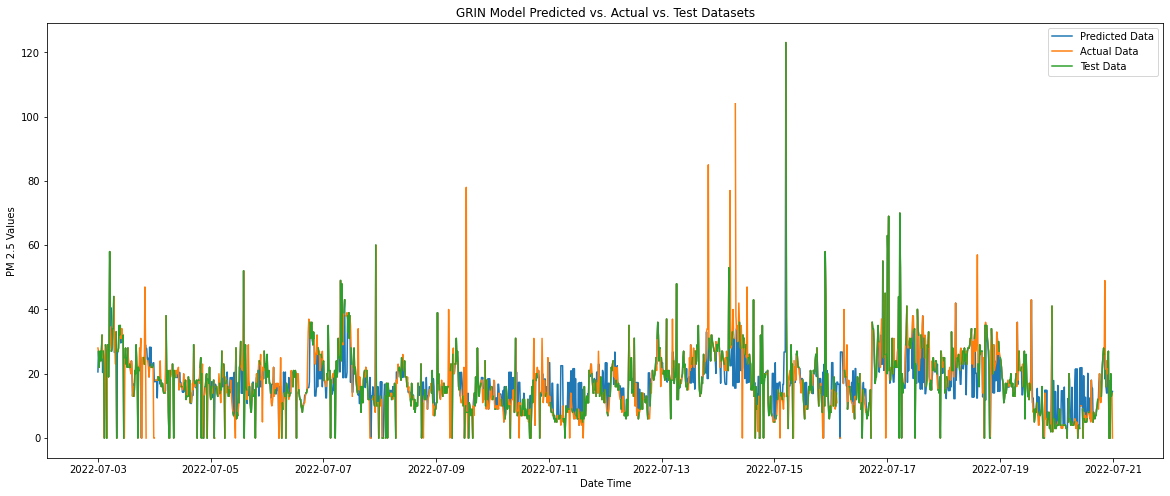

In [176]:
sensor = 0
begin = 60000
data_len = len(DateTime)-1
plt.figure(figsize=(20,8))
plt.plot(DateTime[begin:data_len], y_hat.iloc[begin:data_len, sensor].values, label = 'Predicted Data')
plt.plot(DateTime[begin:data_len], Tdata.T.iloc[begin:data_len, sensor].values, label = 'Actual Data')
plt.plot(DateTime[begin:data_len], Testdata.iloc[begin:data_len, sensor].values, label = 'Test Data')
#plt.legend('Predicted Data','Actual Data','Test Data')
plt.legend(fontsize=18)
plt.title("GRIN Model Predicted vs. Actual vs. Test Datasets",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)
plt.savefig('GRIN_Model_Result_Latest.png', dpi = 300)

### Import packages for IterativeImputer

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

### Separate Test Data and Actual Data for Iterative Imputer

In [69]:
MICE_data = Tdata.T.to_numpy()
MICE_Testdata = Testdata.to_numpy()
MICE_data.shape

(61728, 50)

### Imputer Model with Bayesian Ridge Estimator

In [38]:
MICE_br_Imp = IterativeImputer(random_state=0, estimator=BayesianRidge(), max_iter=25, tol=1e-3)

### Fit Data with Imputer Model

In [39]:
MICE_br_Imp.fit(MICE_data)
#MICE_rfr_Imp.fit(MICE_data)

IterativeImputer(estimator=BayesianRidge(), max_iter=25, random_state=0)

### Prediction step

In [40]:
MICE_br_pred = MICE_br_Imp.transform(MICE_Testdata)

In [162]:
MICE_br_pred.shape
MICE_data.shape

#MICE_br_pred.tofile('MICE_Imputed_Pune_Data.csv', sep=',')
mask_arr[:,:-1].shape

(61728, 50)

### Print different error metrics

In [164]:
sensor = 0
begin = 60000
data_len = len(DateTime)-1
print(numpy_metrics.masked_mae(MICE_br_pred[begin:data_len, sensor], MICE_data[begin:data_len, sensor], mask_arr[begin:data_len, sensor]))
print(numpy_metrics.masked_mre(MICE_br_pred[begin:data_len, sensor], MICE_data[begin:data_len, sensor], mask_arr[begin:data_len, sensor]))
print(numpy_metrics.masked_mape(MICE_br_pred[begin:data_len, sensor], MICE_data[begin:data_len, sensor], mask_arr[begin:data_len, sensor]))

5.431550201781802
0.306610110617084
14892315.147247873


### Plot Real Data, Test Data, and Imputed Data with Iterative Imputer

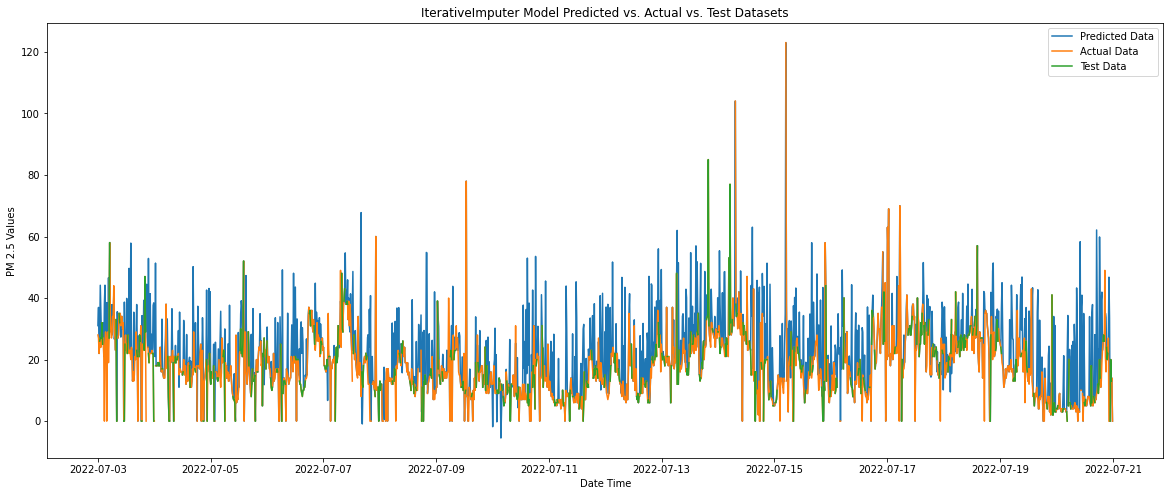

In [156]:
sensor = 0
begin = 60000
data_len = len(DateTime)-1
plt.figure(figsize=(20,8))
plt.plot(DateTime[begin:data_len], MICE_br_pred[begin:data_len, sensor], label = 'Predicted Data')
plt.plot(DateTime[begin:data_len], MICE_data[begin:data_len, sensor], label = 'Actual Data')
plt.plot(DateTime[begin:data_len], MICE_Testdata[begin:data_len, sensor], label = 'Test Data')
#plt.legend('Predicted Data','Actual Data','Test Data')
plt.legend(fontsize=18)
plt.title("IterativeImputer Model Predicted vs. Actual vs. Test Datasets",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)
plt.savefig('MICE_Model_Result_Latest.png', dpi = 300)

In [ ]:
sensor = 1
begin = 0
data_len = len(DateTime)-1
plt.figure(figsize=(20,8))
plt.plot(DateTime[begin:data_len], MICE_br_pred[begin:data_len, sensor], label = 'IterativeImputer')
plt.plot(DateTime[begin:data_len], y_hat.iloc[begin:data_len, sensor].values, label = 'GRIN')
plt.plot(DateTime[begin:data_len], Tdata.T.iloc[begin:data_len, sensor].values, label = 'Actual Data')
#plt.plot(DateTime[begin:data_len], Testdata.iloc[begin:data_len, sensor].values, label = 'Test Data')
plt.legend(fontsize=18)
plt.title("IterativeImputer Model vs. GRIN",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)
#plt.savefig('MICE_vs_GRIN_Model_Result_Last3Days.png', dpi = 300)